In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import numpy as np
import time # For adding a small delay between requests
import requests
from urllib.parse import quote_plus # This is crucial for URL encoding
from urllib.parse import urlencode
import sqlite3

In [3]:
# Step 3: Connect to SQLite and prepare the table
db_path = "nyc_crashes.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Read the entire 'crashes' table into a DataFrame
nyc_data_df = pd.read_sql_query("SELECT * FROM crashes", conn)

# Close connection
conn.close()

In [4]:
injury_stats = nyc_data_df['number_of_persons_injured'].describe()
fatality_stats = nyc_data_df['number_of_persons_killed'].describe()
injury_stats, fatality_stats

(count    1.980526e+06
 mean     2.972736e-01
 std      6.883178e-01
 min      0.000000e+00
 25%      0.000000e+00
 50%      0.000000e+00
 75%      0.000000e+00
 max      4.300000e+01
 Name: number_of_persons_injured, dtype: float64,
 count    1.980513e+06
 mean     1.425893e-03
 std      3.976677e-02
 min      0.000000e+00
 25%      0.000000e+00
 50%      0.000000e+00
 75%      0.000000e+00
 max      8.000000e+00
 Name: number_of_persons_killed, dtype: float64)

In [5]:
# TODO: Calculate top vehicles for injuries
top_vehicles_injuries = nyc_data_df.groupby('vehicle_type_code1')['number_of_persons_injured'].sum().sort_values(ascending=False).head(10)
# TODO: Calculate top vehicles for deaths
top_vehicles_deaths = nyc_data_df.groupby('vehicle_type_code1')['number_of_persons_killed'].sum().sort_values(ascending=False).head(10)
top_vehicles_injuries, top_vehicles_deaths

(vehicle_type_code1
 Sedan                                  174510.0
 Station Wagon/Sport Utility Vehicle    133533.0
 PASSENGER VEHICLE                      106857.0
 SPORT UTILITY / STATION WAGON           45622.0
 Taxi                                    16870.0
 Bike                                    11593.0
 4 dr sedan                              11309.0
 TAXI                                     8171.0
 Pick-up Truck                            7793.0
 UNKNOWN                                  7652.0
 Name: number_of_persons_injured, dtype: float64,
 vehicle_type_code1
 Sedan                                  579.0
 Station Wagon/Sport Utility Vehicle    533.0
 PASSENGER VEHICLE                      398.0
 SPORT UTILITY / STATION WAGON          218.0
 Motorcycle                             166.0
 MOTORCYCLE                              91.0
 UNKNOWN                                 61.0
 Pick-up Truck                           55.0
 Box Truck                               54.0
 Bus  

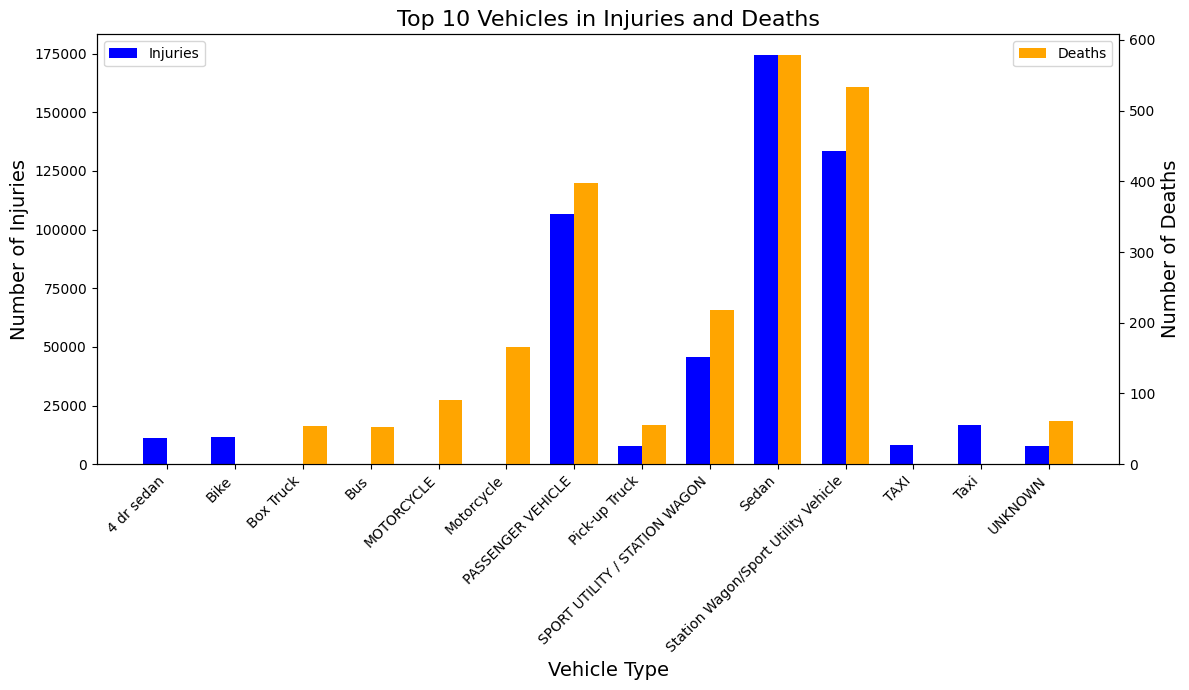

In [6]:

# TODO: Combine the data into a DataFrame
combined_data = pd.DataFrame({'Injuries': top_vehicles_injuries, 'Deaths': top_vehicles_deaths})

# Set the width of the bars
bar_width = 0.35

# Plotting the combined bar chart with bars next to each other
fig, ax1 = plt.subplots(figsize=(12, 7))

# Generate a list of indices for the x-axis
indices = np.arange(len(combined_data))

# Plotting the bars for injuries
ax1.bar(indices - bar_width/2, combined_data['Injuries'], bar_width, color='blue', label='Injuries')

# TODO: Create a secondary y-axis for deaths
ax2 = ax1.twinx()

# Plotting the bars for deaths next to injuries
ax2.bar(indices + bar_width/2, combined_data['Deaths'], bar_width, color='orange', label='Deaths')

# Adding labels and title
ax1.set_title('Top 10 Vehicles in Injuries and Deaths', fontsize=16)
ax1.set_xlabel('Vehicle Type', fontsize=14)
ax1.set_ylabel('Number of Injuries', fontsize=14)
# TODO: Set the label for the secondary y-axis
ax2.set_ylabel('Number of Deaths', fontsize=14)
ax1.set_xticks(indices)
ax1.set_xticklabels(combined_data.index, rotation=45, ha='right')

# Adding legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adjusting layout and displaying the combined chart
plt.tight_layout()
plt.show()